In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np 
import shap 
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# todo 
# create unit tests 
# time series validation ? - look into this
# use different dataset which breaks down the data into time of day to get more accurate predictions 

In [3]:
data = pd.read_csv('combined_data_more.csv')

In [4]:
timedata = pd.read_csv('timedata.csv')

In [5]:
data.head()

,Year,Month,Day,Mean Temp (°C)
0,2011,1,1,5.7
1,2011,1,2,-2.1
2,2011,1,3,-3.1
3,2011,1,4,-1.8
4,2011,1,5,-5.9


In [6]:
timedata.head()

,Year,Month,Day,Time (UTC),Temp (°C)
0,2023,1,1,00:00,5.6
1,2023,1,1,01:00,4.5
2,2023,1,1,02:00,3.7
3,2023,1,1,03:00,2.8
4,2023,1,1,04:00,1.8


In [7]:
data.isnull().sum()

Year              0
Month             0
Day               0
Mean Temp (°C)    0
dtype: int64

In [8]:
timedata.dtypes

Year            int64
Month           int64
Day             int64
Time (UTC)     object
Temp (°C)     float64
dtype: object

In [9]:
def time_to_float(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    return time_obj.hour + time_obj.minute / 60.0

In [10]:
timedata["Time (UTC)"] = timedata["Time (UTC)"].apply(time_to_float)

In [11]:
X = data[["Year", "Month", "Day"]]

In [12]:
y = data["Mean Temp (°C)"]

In [13]:
X2 = timedata[["Year", "Month", "Day", "Time (UTC)"]]

In [14]:
y2 = timedata["Temp (°C)"]

In [15]:
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['day_of_year'] = data['date'].dt.dayofyear

<Axes: xlabel='date'>

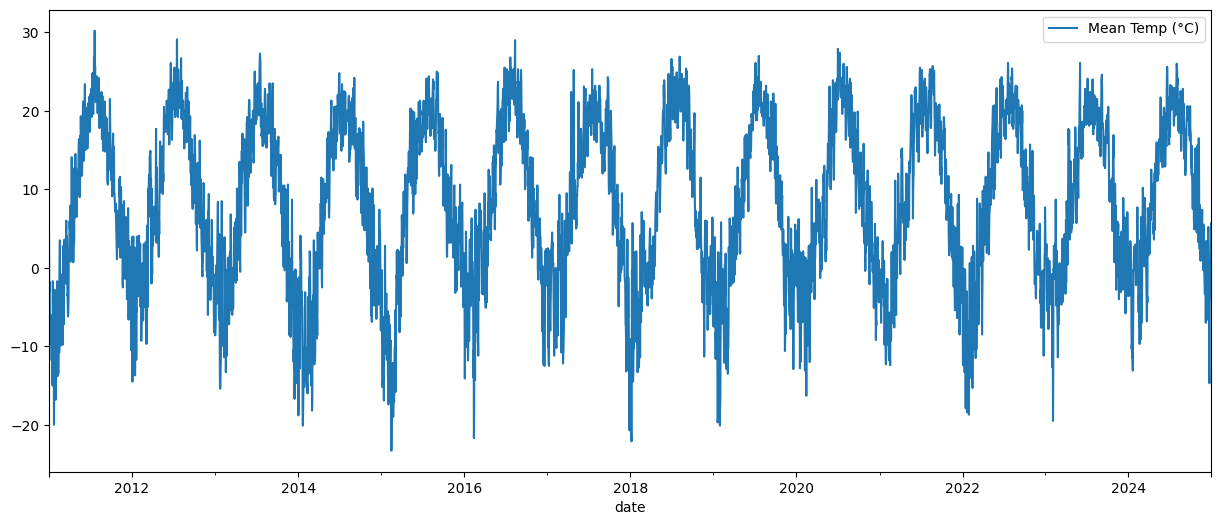

In [16]:
data.plot(x='date', y='Mean Temp (°C)', figsize=(15, 6))    

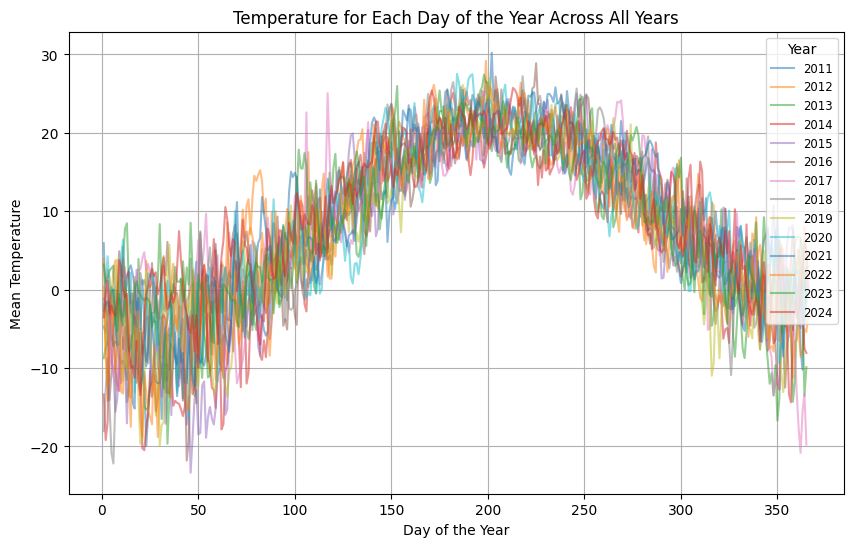

In [17]:
plt.figure(figsize=(10, 6))
for year in data['Year'].unique():
    yearly_data = data[data['Year'] == year]
    jitter = np.random.uniform(-0.4, 0.4, size=len(yearly_data))
    plt.plot(yearly_data['day_of_year'], yearly_data['Mean Temp (°C)'] + jitter, label=year, alpha=0.5)

plt.title('Temperature for Each Day of the Year Across All Years')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Temperature')
plt.legend(title='Year', loc='upper right', fontsize='small', markerscale=2)
plt.grid(True)
plt.show()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=80, shuffle=True)

In [19]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=80, shuffle=True)

In [20]:
y_train.count, " ", y2_train.count

(<bound method Series.count of 4085    -0.9
 740      1.9
 4777     0.3
 4018     0.6
 2608     2.4
         ... 
 2423    19.5
 522     17.2
 2259    -0.4
 2982    -5.2
 1199    10.5
 Name: Mean Temp (°C), Length: 4602, dtype: float64>,
 ' ',
 <bound method Series.count of 15534     0.4
 15491     8.1
 13269    20.6
 14752     8.6
 10616    16.0
          ... 
 7638     15.8
 15154     1.6
 8714     20.8
 2259     -0.4
 5308      8.5
 Name: Temp (°C), Length: 15789, dtype: float64>)

In [21]:
y_test.count, " ", y2_test.count

(<bound method Series.count of 4528    12.5
 74       2.5
 3148    19.1
 195     19.6
 2228    -2.3
         ... 
 4550    18.4
 3614     1.3
 678      4.0
 4421     1.2
 1639    14.8
 Name: Mean Temp (°C), Length: 512, dtype: float64>,
 ' ',
 <bound method Series.count of 13652     9.2
 15971     0.6
 8329     17.9
 11156    26.3
 7345     16.0
          ... 
 2518     -1.0
 10933    13.9
 10416    23.0
 6201      1.0
 534      -2.0
 Name: Temp (°C), Length: 1755, dtype: float64>)

In [22]:
xgr = xgb.XGBRegressor(objective="reg:squarederror", subsample= 0.8, n_estimators= 1500, max_depth=30, learning_rate=0.1, eta= 0.1, colsample_bytree= 1.0)
xgr2 = xgb.XGBRegressor(objective="reg:squarederror", subsample= 0.8, n_estimators= 1500, max_depth=30, learning_rate=0.1, eta= 0.1, colsample_bytree= 1.0)

In [23]:
xgr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
xgr2.fit(x2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
pred = xgr.predict(x_test)
pred2 = xgr2.predict(x2_test)

In [26]:
mae = np.abs(mean_absolute_error(y_test, pred))
print("MAE : % f " %(mae))

MAE :  2.366743 


In [27]:
mae2 = np.abs(mean_absolute_error(y2_test, pred2))
print("MAE : % f " %(mae2))

MAE :  0.644105 


In [28]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [29]:
dtrain2 = xgb.DMatrix(x2_train, label=y2_train)
dtest2 = xgb.DMatrix(x2_test, label=y2_test)

In [30]:
# {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 30, 'learning_rate': 0.05, 'eta': 0.1, 'colsample_bytree': 1.0}
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 30,
    'eta': 0.1,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
}

In [31]:
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=4, verbose_eval=10)

[0]	test-rmse:9.67556
[10]	test-rmse:6.57394
[20]	test-rmse:4.92432
[30]	test-rmse:4.08113
[40]	test-rmse:3.64058
[50]	test-rmse:3.42219
[60]	test-rmse:3.29706
[70]	test-rmse:3.23644
[80]	test-rmse:3.19476
[90]	test-rmse:3.17461
[99]	test-rmse:3.16573


In [34]:
model2 = xgb.train(params, dtrain2, num_boost_round=1000, evals=[(dtest2, 'test')], early_stopping_rounds=2, verbose_eval=2)

[0]	test-rmse:9.39168


[2]	test-rmse:8.56519
[4]	test-rmse:7.81519
[6]	test-rmse:7.13692
[8]	test-rmse:6.52947
[10]	test-rmse:5.97789
[12]	test-rmse:5.47794
[14]	test-rmse:5.03259
[16]	test-rmse:4.62292
[18]	test-rmse:4.25857
[20]	test-rmse:3.93014
[22]	test-rmse:3.63291
[24]	test-rmse:3.36661
[26]	test-rmse:3.12400
[28]	test-rmse:2.90247
[30]	test-rmse:2.70735
[32]	test-rmse:2.52744
[34]	test-rmse:2.36793
[36]	test-rmse:2.22579
[38]	test-rmse:2.09416
[40]	test-rmse:1.97921
[42]	test-rmse:1.87546
[44]	test-rmse:1.77927
[46]	test-rmse:1.69428
[48]	test-rmse:1.61790
[50]	test-rmse:1.54802
[52]	test-rmse:1.48595
[54]	test-rmse:1.43081
[56]	test-rmse:1.38314
[58]	test-rmse:1.33911
[60]	test-rmse:1.29834
[62]	test-rmse:1.26227
[64]	test-rmse:1.22951
[66]	test-rmse:1.19997
[68]	test-rmse:1.17235
[70]	test-rmse:1.14749
[72]	test-rmse:1.12696
[74]	test-rmse:1.10688
[76]	test-rmse:1.08845
[78]	test-rmse:1.07412
[80]	test-rmse:1.05978
[82]	test-rmse:1.04823
[84]	test-rmse:1.03651
[86]	test-rmse:1.02618
[88]	test-rmse:

In [35]:
def evaluatemodel(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return ("MSE:", mse, "MAE:", mae, "R2:", r2)

In [36]:
evaluatemodel(xgr, x_test, y_test)

('MSE:',
 9.769756543183396,
 'MAE:',
 2.3667428282242327,
 'R2:',
 0.9036195894420294)

In [37]:
evaluatemodel(xgr2, x2_test, y2_test)

('MSE:',
 0.82231423372847,
 'MAE:',
 0.6441049066736785,
 'R2:',
 0.9914983413929115)

In [37]:
# can find best parameters for model using parameter search
param_dist = {
    'max_depth': [15, 20, 30, 50],
    'learning_rate': [0.05, 0.08, 0.1, 0.2],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [1000, 1500, 2000]
}
randomsearch = RandomizedSearchCV(
    estimator=xgr2,
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=1,
    n_jobs=-1
)

In [46]:
randomsearch.fit(x2_train, y2_train)
print("Best Params: ", randomsearch.best_params_)
print("Best score: % f " % np.abs(randomsearch.best_score_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Params:  {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 30, 'learning_rate': 0.05, 'eta': 0.1, 'colsample_bytree': 1.0}
Best score:  0.997745 


In [45]:
#shap value stuff below

In [46]:
xgb_explainer = shap.Explainer(model2, x2_train)
shap_values = xgb_explainer(X2)

100%|===================| 17543/17544 [11:19<00:00]        

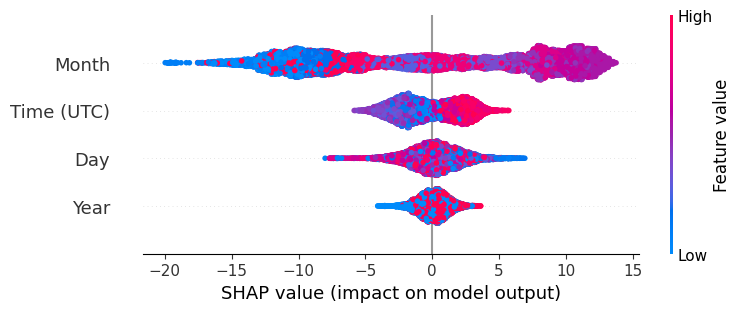

In [47]:
shap.plots.beeswarm(shap_values)

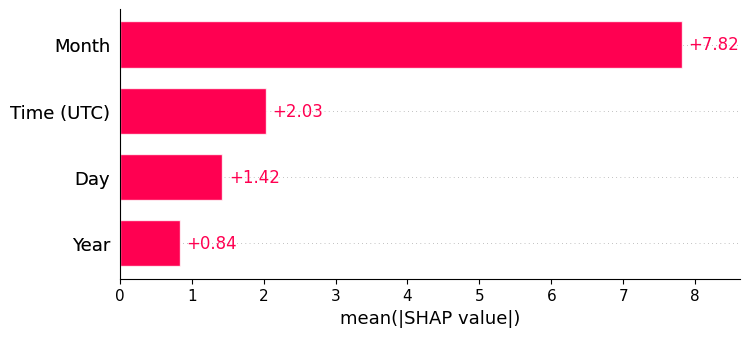

In [48]:
shap.plots.bar(shap_values)

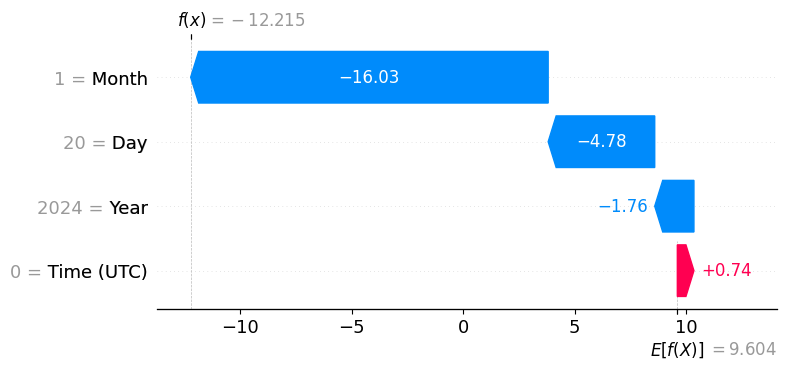

In [49]:
shap.plots.waterfall(shap_values[1200])

In [38]:
def predict_future_temp(year, month, day):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day]})
    future_temp = model.predict(xgb.DMatrix(future_date))
    return future_temp[0]


In [39]:
def predict_future_temp_time(year, month, day, time):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day], "Time (UTC)": [time]})
    future_temp = model2.predict(xgb.DMatrix(future_date))
    return future_temp[0]

In [40]:
predict_future_temp(2025, 3, 25) 

6.649413

In [46]:
predict_future_temp_time(2024, 2, 8, 5)

-1.0934314

In [68]:
model2.save_model("xgboost_regressor_time_model.json")